In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential,mixed_precision
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import InputLayer,Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,RandomBrightness
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

import os
os.chdir('/tf-acno-projects/image-classification/')
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

2024-11-01 15:13:19.688129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 15:13:19.699701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 15:13:19.703151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 15:13:19.711793: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.optimizer.set_jit(True)  # Enable XLA
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]  # Limit GPU memory usage
            )
            print(f"Memory limit set for GPU")
    except RuntimeError as e:
        print(e)
        
# Before training
mixed_precision.set_global_policy('mixed_float16')
print("\nXLA Status Check:")
print(f"XLA JIT enabled: {tf.config.optimizer.get_jit()}")
print(f"XLA devices: {tf.config.list_logical_devices('XLA_GPU')}")

Memory limit set for GPU

XLA Status Check:
XLA JIT enabled: autoclustering
XLA devices: [LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]


I0000 00:00:1730474001.410236   42128 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730474001.414243   42128 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730474001.414278   42128 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730474001.422834   42128 service.cc:146] XLA service 0x61cb730 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730474001.422859   42128 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1730474001.517226   42177 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/num

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
data_dir = 'faces_data/'
input_shape=(128,128,3)

In [4]:
data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomFlip("horizontal"),
    RandomBrightness(0.1),
])

In [5]:
def prepare_dataset(ds, batch_size, is_training=True):

    # Normalize images
    ds = ds.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=AUTOTUNE
    )

    if is_training:
        ds = ds.shuffle(4000)
        
    ds = ds.batch(batch_size)
    
        
    return ds.prefetch(AUTOTUNE)

In [ ]:
    # data_aug images
    """
    if is_training:
        ds = ds.map(
           lambda x,y: (data_augmentation(x,training=True),y),
           num_parallel_calls=AUTOTUNE
       )"""

In [6]:
def get_class_distribution(dataset):
    class_counts = tf.zeros(5, dtype=tf.int32)
    for _, labels in dataset:
        class_counts += tf.cast(labels, tf.int32) # each individual sample's label in the dataset ; ( use reduce_sum if it was batched)
    return class_counts.numpy()


In [7]:
def plot_training_history(train_acc,val_acc,train_loss,val_loss):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [8]:
def create_model1():
       regularization_value = 0.0001    
       model = Sequential([
              InputLayer(shape=input_shape),
              Conv2D(8,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value),
                     ),
              MaxPooling2D(),
              #Dropout(0.1),
              Conv2D(16,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              MaxPooling2D(),
              Conv2D(8,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              MaxPooling2D(),
              #Dropout(0.2), 
              Flatten(),
                     
              Dense(32,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              Dropout(0.4),
              Dense(5,
                     activation='softmax',
                     #kernel_initializer='glorot_uniform'
                     )
       ])
       
       return model

def create_model2():
       regularization_value = 0.001    
       model = Sequential([
              InputLayer(shape=input_shape),
              Conv2D(16,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value),
                     ),
              MaxPooling2D(),
              #Dropout(0.1),
              Conv2D(32,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              MaxPooling2D(),
              Conv2D(64,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              MaxPooling2D(),
              #Dropout(0.2), 
              Flatten(),
                     
              Dense(64,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              Dropout(0.4),
              Dense(32,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              Dropout(0.2),
              Dense(5,
                     activation='softmax',
                     #kernel_initializer='glorot_uniform'
                     )
       ])
       
       return model

def create_model3():
       regularization_value = 0.0005    
       model = Sequential([
              InputLayer(shape=input_shape),
              Conv2D(16,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value),
                     ),
              MaxPooling2D(),
              #Dropout(0.1),
              Conv2D(32,(3,3),
                     strides=1,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              MaxPooling2D(),
              #Dropout(0.2), 
              Flatten(),
                     
              Dense(64,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              Dropout(0.5),
              Dense(32,
                     #kernel_initializer='he_normal',
                     activation='relu',
                     kernel_regularizer=l2(regularization_value)
                     ),
              Dropout(0.2),
              Dense(5,
                     activation='softmax',
                     #kernel_initializer='glorot_uniform'
                     )
       ])
       
       return model

In [9]:

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(128, 128),
    label_mode='categorical',# Ensure labels are one-hot encoded
    batch_size= None,
)
# Check class names and indices
class_names = dataset.class_names
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}, Index: {i}\n")
    

Found 4640 files belonging to 5 classes.
Class: angry, Index: 0

Class: disgusted, Index: 1

Class: happy, Index: 2

Class: sad, Index: 3

Class: shocked, Index: 4



In [10]:
DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()
# Define the sizes of your splits
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = DATASET_SIZE - train_size - val_size

# Split the dataset
train_dataset = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

In [11]:
# Get one batch of data
for images, labels in train_dataset.take(1):  # Take 1 batch
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels.numpy())  # Convert to numpy array for easier viewing

# Check the unique values in labels to determine the format
unique_labels = tf.unique(tf.reshape(labels, [-1]))  # Flatten labels to check unique values
print("Unique label values:", unique_labels.y.numpy())


Images shape: (128, 128, 3)
Labels shape: (5,)
Labels: [0. 0. 0. 1. 0.]
Unique label values: [0. 1.]


2024-11-01 15:13:27.099748: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
train_dist = get_class_distribution(train_dataset)
print("\nClass distribution in training set:")
for i, count in enumerate(train_dist):
    print(f"Class {i}: {count} samples")

# Calculate class weights
total_samples = sum(train_dist)
n_classes = len(train_dist)
class_weights = {
    i: total_samples / (n_classes * count) if count> 0 else 0
    for i, count in enumerate(train_dist)
}

print("\nClass weights:")
for class_idx, weight in class_weights.items():
    print(f"Class {class_idx}: {weight:.2f}")


Class distribution in training set:
Class 0: 1217 samples
Class 1: 392 samples
Class 2: 976 samples
Class 3: 537 samples
Class 4: 590 samples

Class weights:
Class 0: 0.61
Class 1: 1.89
Class 2: 0.76
Class 3: 1.38
Class 4: 1.26


2024-11-01 15:13:29.282292: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
callbacks = [
    #EarlyStopping(monitor='val_loss',patience=20,min_delta=0.00001),
    ReduceLROnPlateau(monitor="val_loss",factor=0.8, patience=5,min_delta=0.001,min_lr=5e-5),
]

In [14]:
input_shape = (128,128,3)
batch_sizes = [8,16,32]
learning_rates=[0.002,0.001,0.0005,0.0001]
Epochs = 100
results1,results2,results3 = [],[],[]

train_datasets = [prepare_dataset(train_dataset, batch_size) for batch_size in batch_sizes]
val_datasets = [prepare_dataset(val_dataset, batch_size, is_training=False) for batch_size in batch_sizes]

In [ ]:
for i, batch_size in enumerate(batch_sizes):
    train_ds = train_datasets[i]
    val_ds = val_datasets[i]
    
    for lr in learning_rates:
        tf.keras.backend.clear_session()

        model1 = create_model1()

        model1.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=lr)),loss=CategoricalCrossentropy(),metrics=['accuracy'])
 
        training_history1 = model1.fit(train_ds,epochs=Epochs,validation_data=val_ds,class_weight=class_weights,callbacks=callbacks,verbose=0)

        # Evaluate on validation set
        val_loss1, val_accuracy1 = model1.evaluate(val_ds, verbose=0)

        print(f"FOR Batch : {batch_size} , LR : {lr} we have \tEpochs : {len(training_history1.history['loss'])} Val Accuracy : {val_accuracy1:.4f} , Val Loss : {val_loss1:.4f}")

        results1.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy1,
            'val_loss': val_loss1,
            'history':training_history1.history
        })
        

Epoch 1/100


2024-11-01 15:13:30.987786: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-01 15:13:31.149088: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 59/464 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1730 - loss: 1.6623

2024-11-01 15:13:33.476993: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 68 bytes spill stores, 68 bytes spill loads

I0000 00:00:1730474013.486550   42188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


464/464 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2174 - loss: 1.6252 - val_accuracy: 0.3664 - val_loss: 1.4984 - learning_rate: 0.0020
Epoch 2/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2984 - loss: 1.5920 - val_accuracy: 0.4483 - val_loss: 1.4555 - learning_rate: 0.0020
Epoch 3/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3268 - loss: 1.5496 - val_accuracy: 0.3815 - val_loss: 1.4679 - learning_rate: 0.0020
Epoch 4/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3651 - loss: 1.4823 - val_accuracy: 0.4267 - val_loss: 1.3730 - learning_rate: 0.0020
Epoch 5/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4130 - loss: 1.4139 - val_accuracy: 0.4612 - val_loss: 1.3239 - learning_rate: 0.0020
Epoch 6/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4368 - loss: 1.3360 - val_accuracy: 0.4547 - val_loss: 1.3188 - learning_rate: 0.0020
Epoch 7/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.2815 - val_a

In [16]:

for i, batch_size in enumerate(batch_sizes):
    train_ds = train_datasets[i]
    val_ds = val_datasets[i]
    
    for lr in learning_rates:
        tf.keras.backend.clear_session()


        model2 = create_model2()
        
   
        model2.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=lr)),loss=CategoricalCrossentropy(),metrics=['accuracy'])


        training_history2 = model2.fit(train_ds,epochs=Epochs,validation_data=val_ds,class_weight=class_weights,callbacks=callbacks,verbose=0)

        # Evaluate on validation set
        val_loss2, val_accuracy2 = model2.evaluate(val_ds, verbose=0)

        print(f"FOR Batch : {batch_size} , LR : {lr} we have \tEpochs : {len(training_history2.history['loss'])} Val Accuracy : {val_accuracy2:.4f} , Val Loss : {val_loss2:.4f}")
  
        results2.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy2,
            'val_loss': val_loss2,
            'history':training_history2.history
        })


2024-11-01 15:49:50.200406: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 68 bytes spill stores, 68 bytes spill loads



FOR Batch : 8 , LR : 0.002 we have 	Epochs : 100 Val Accuracy : 0.1056 , Val Loss : 1.6106
FOR Batch : 8 , LR : 0.001 we have 	Epochs : 100 Val Accuracy : 0.1444 , Val Loss : 1.6105
FOR Batch : 8 , LR : 0.0005 we have 	Epochs : 100 Val Accuracy : 0.8966 , Val Loss : 0.4153
FOR Batch : 8 , LR : 0.0001 we have 	Epochs : 100 Val Accuracy : 0.9138 , Val Loss : 0.3830
FOR Batch : 16 , LR : 0.002 we have 	Epochs : 100 Val Accuracy : 0.1142 , Val Loss : 1.6113
FOR Batch : 16 , LR : 0.001 we have 	Epochs : 100 Val Accuracy : 0.6401 , Val Loss : 0.9343
FOR Batch : 16 , LR : 0.0005 we have 	Epochs : 100 Val Accuracy : 0.7672 , Val Loss : 0.6787
FOR Batch : 16 , LR : 0.0001 we have 	Epochs : 100 Val Accuracy : 0.8664 , Val Loss : 0.4960
FOR Batch : 32 , LR : 0.002 we have 	Epochs : 100 Val Accuracy : 0.5991 , Val Loss : 1.0771
FOR Batch : 32 , LR : 0.001 we have 	Epochs : 100 Val Accuracy : 0.8103 , Val Loss : 0.5821
FOR Batch : 32 , LR : 0.0005 we have 	Epochs : 100 Val Accuracy : 0.8707 , Val L

In [17]:
for i, batch_size in enumerate(batch_sizes):
    train_ds = train_datasets[i]
    val_ds = val_datasets[i]
    
    for lr in learning_rates:
        tf.keras.backend.clear_session()

        model3 = create_model3()
        
        model3.compile(optimizer=mixed_precision.LossScaleOptimizer(Adam(learning_rate=lr)),loss=CategoricalCrossentropy(),metrics=['accuracy'])

        training_history3 = model3.fit(train_ds,epochs=Epochs,validation_data=val_ds,class_weight=class_weights,callbacks=callbacks,verbose=0)
                                        
        # Evaluate on validation set
        val_loss3, val_accuracy3 = model3.evaluate(val_ds, verbose=0)
        
      
        print(f"FOR Batch : {batch_size} , LR : {lr} we have \tEpochs : {len(training_history3.history['loss'])} Val Accuracy : {val_accuracy3:.4f} , Val Loss : {val_loss3:.4f}")

        results3.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy3,
            'val_loss': val_loss3,
            'history':training_history3.history
        })
        

2024-11-01 17:04:18.786604: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 68 bytes spill stores, 68 bytes spill loads



FOR Batch : 8 , LR : 0.002 we have 	Epochs : 100 Val Accuracy : 0.8017 , Val Loss : 0.6546
FOR Batch : 8 , LR : 0.001 we have 	Epochs : 100 Val Accuracy : 0.8664 , Val Loss : 0.5017
FOR Batch : 8 , LR : 0.0005 we have 	Epochs : 100 Val Accuracy : 0.9030 , Val Loss : 0.3527
FOR Batch : 8 , LR : 0.0001 we have 	Epochs : 100 Val Accuracy : 0.9116 , Val Loss : 0.3241
FOR Batch : 16 , LR : 0.002 we have 	Epochs : 100 Val Accuracy : 0.7629 , Val Loss : 0.7009
FOR Batch : 16 , LR : 0.001 we have 	Epochs : 100 Val Accuracy : 0.8793 , Val Loss : 0.4647
FOR Batch : 16 , LR : 0.0005 we have 	Epochs : 100 Val Accuracy : 0.8922 , Val Loss : 0.3983
FOR Batch : 16 , LR : 0.0001 we have 	Epochs : 100 Val Accuracy : 0.9181 , Val Loss : 0.3277
FOR Batch : 32 , LR : 0.002 we have 	Epochs : 100 Val Accuracy : 0.8384 , Val Loss : 0.5845
FOR Batch : 32 , LR : 0.001 we have 	Epochs : 100 Val Accuracy : 0.9073 , Val Loss : 0.3766
FOR Batch : 32 , LR : 0.0005 we have 	Epochs : 100 Val Accuracy : 0.8836 , Val L

#### remark:
- High lr works better for big batch size
- Low lr works better for small batch size


Best parameters: MODEL 1
Batch Size: 32
Learning Rate: 0.0010
Validation Accuracy: 0.9073
Validation Loss: 0.2773
Accuracy: 0.8311
Loss: 0.3591

Best parameters: MODEL 2
Batch Size: 8
Learning Rate: 0.0001
Validation Accuracy: 0.9138
Validation Loss: 0.3830
Accuracy: 0.8890
Loss: 0.4187

Best parameters: MODEL 3
Batch Size: 8
Learning Rate: 0.0001
Validation Accuracy: 0.9116
Validation Loss: 0.3241
Accuracy: 0.8742
Loss: 0.4059


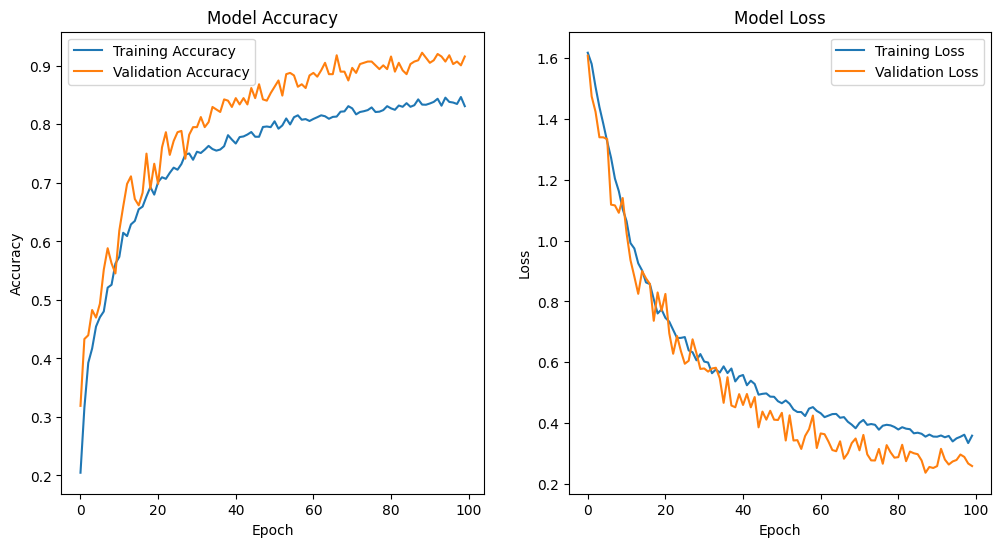

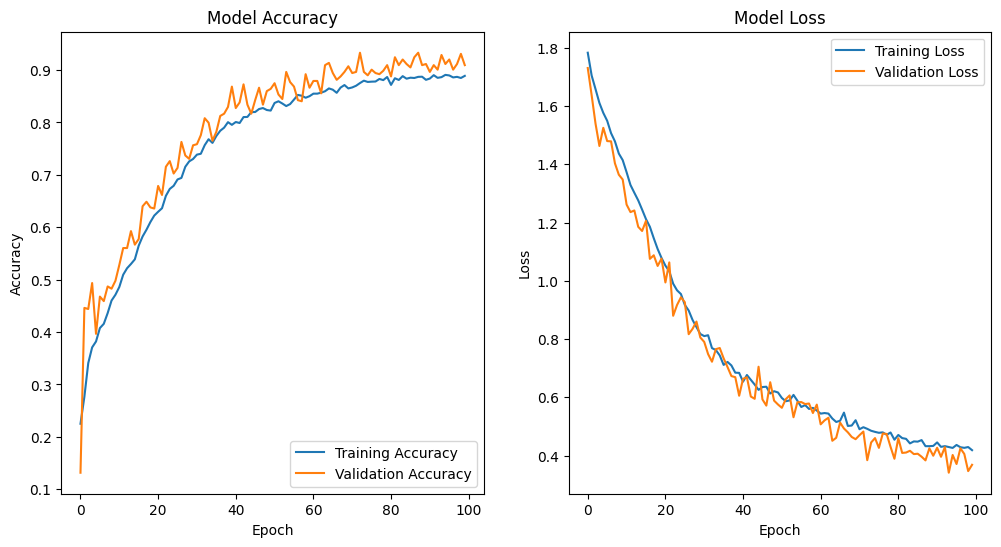

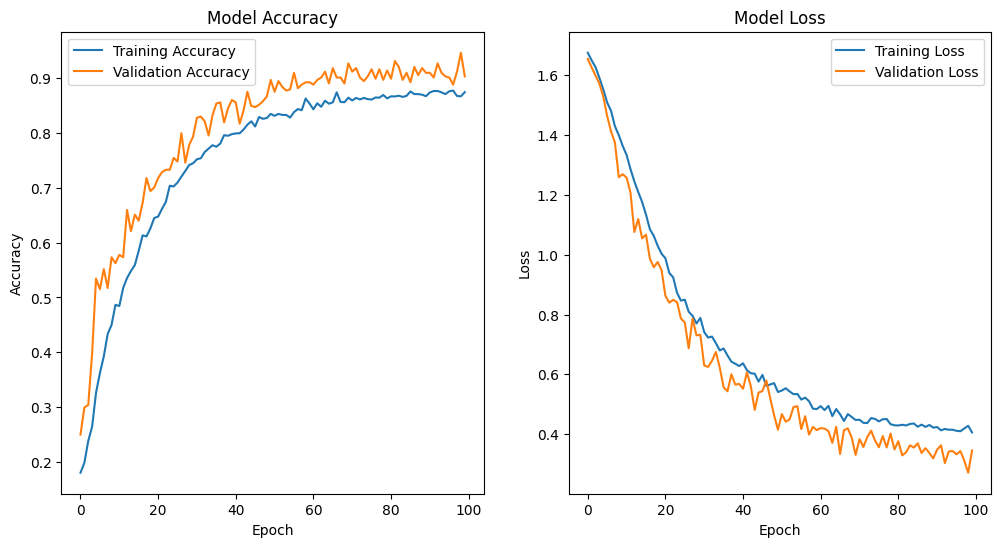

In [20]:
best_result = min(results1, key=lambda x: x['val_loss'])
best_result2 = min(results2, key=lambda x: x['val_loss'])
best_result3 = min(results3, key=lambda x: x['val_loss'])
best_result_hist = best_result['history']
best_result_hist2 =  best_result2['history']
best_result_hist3 =  best_result3['history']

print("\nBest parameters: MODEL 1")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Learning Rate: {best_result['learning_rate']:.4f}")
print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")
print(f"Validation Loss: {best_result['val_loss']:.4f}")
print(f"Accuracy: {best_result_hist['accuracy'][-1]:.4f}")
print(f"Loss: {best_result_hist['loss'][-1]:.4f}")

print("\nBest parameters: MODEL 2")
print(f"Batch Size: {best_result2['batch_size']}")
print(f"Learning Rate: {best_result2['learning_rate']:.4f}")
print(f"Validation Accuracy: {best_result2['val_accuracy']:.4f}")
print(f"Validation Loss: {best_result2['val_loss']:.4f}")
print(f"Accuracy: {best_result_hist2['accuracy'][-1]:.4f}")
print(f"Loss: {best_result_hist2['loss'][-1]:.4f}")

print("\nBest parameters: MODEL 3")
print(f"Batch Size: {best_result3['batch_size']}")
print(f"Learning Rate: {best_result3['learning_rate']:.4f}")
print(f"Validation Accuracy: {best_result3['val_accuracy']:.4f}")
print(f"Validation Loss: {best_result3['val_loss']:.4f}")
print(f"Accuracy: {best_result_hist3['accuracy'][-1]:.4f}")
print(f"Loss: {best_result_hist3['loss'][-1]:.4f}")

plot_training_history(best_result_hist['accuracy'],best_result_hist['val_accuracy'],best_result_hist['loss'],best_result_hist['val_loss'],)
plot_training_history(best_result_hist2['accuracy'],best_result_hist2['val_accuracy'],best_result_hist2['loss'],best_result_hist2['val_loss'],)
plot_training_history(best_result_hist3['accuracy'],best_result_hist3['val_accuracy'],best_result_hist3['loss'],best_result_hist3['val_loss'],)

In [21]:
# Train final model with best parameters
tf.keras.backend.clear_session()
final_train_batches = prepare_dataset(train_dataset, 32)
final_val_batches = prepare_dataset(val_dataset, 32, is_training=False)

final_train_batches23 = prepare_dataset(train_dataset, 8)
final_val_batches23 = prepare_dataset(val_dataset, 8, is_training=False)

final_model1 = create_model1()
final_model2 = create_model2()
final_model3 = create_model3()

final_model1.compile(optimizer=Adam(learning_rate=best_result['learning_rate']),loss='categorical_crossentropy',metrics=['accuracy'])
final_model2.compile(optimizer=Adam(learning_rate=best_result2['learning_rate']),loss='categorical_crossentropy',metrics=['accuracy'])
final_model3.compile(optimizer=Adam(learning_rate=best_result3['learning_rate']),loss='categorical_crossentropy',metrics=['accuracy'])

final_history1 = final_model1.fit(final_train_batches,epochs=150,validation_data=final_val_batches,class_weight=class_weights,callbacks=callbacks,verbose=0)
final_history2 = final_model2.fit(final_train_batches23,epochs=150,validation_data=final_val_batches23,class_weight=class_weights,callbacks=callbacks,verbose=0)
final_history3 = final_model3.fit(final_train_batches23,epochs=150,validation_data=final_val_batches23,class_weight=class_weights,callbacks=callbacks,verbose=0)



2024-11-01 18:20:52.050980: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 68 bytes spill stores, 68 bytes spill loads

2024-11-01 18:28:14.574865: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 68 bytes spill stores, 68 bytes spill loads



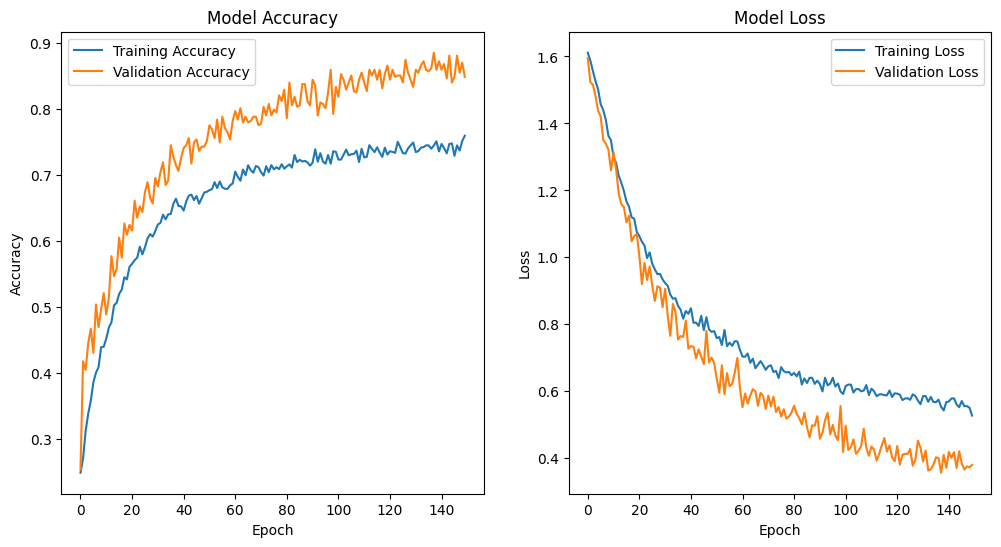

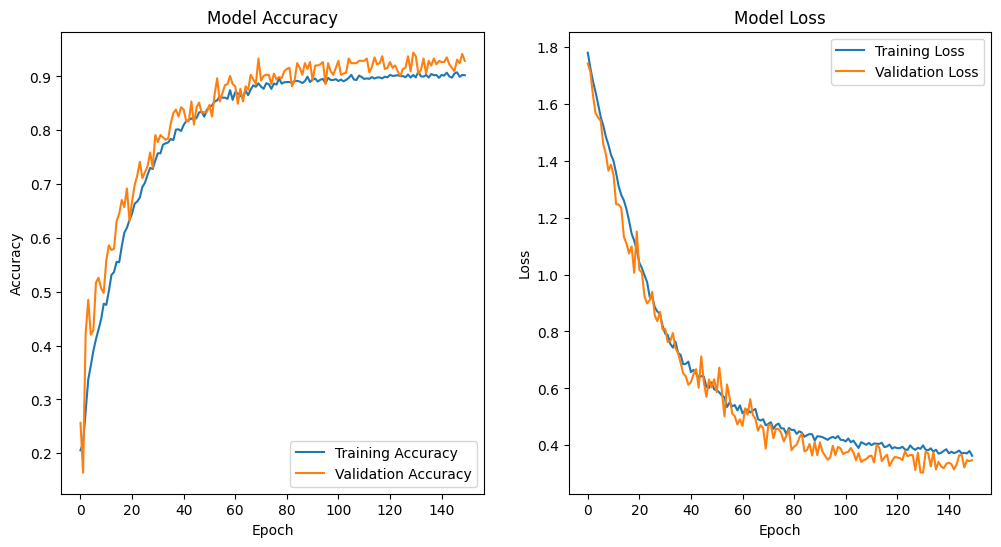

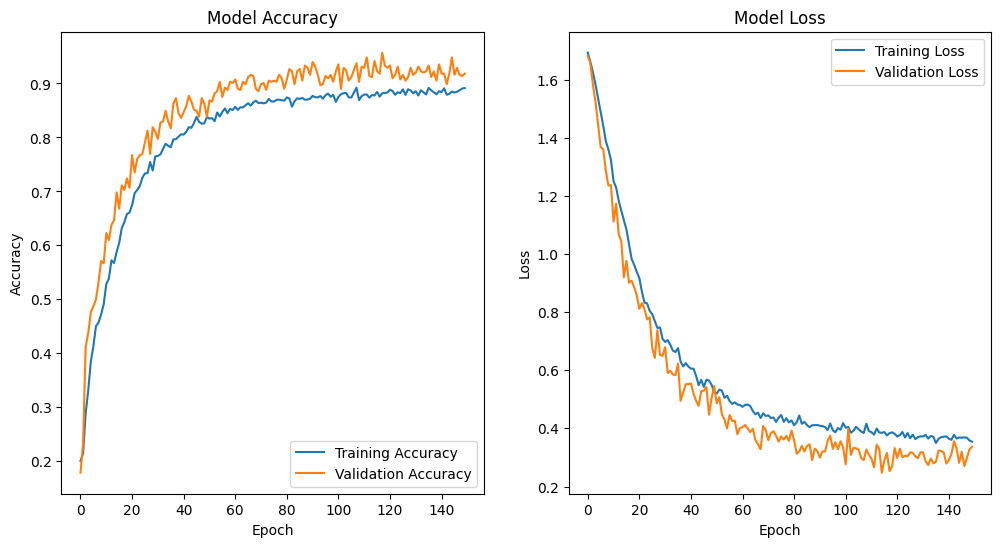

In [22]:
# plot of the training accuracy and loss
plot_training_history(final_history1.history['accuracy'],final_history1.history['val_accuracy'],final_history1.history['loss'],final_history1.history['val_loss'])
plot_training_history(final_history2.history['accuracy'],final_history2.history['val_accuracy'],final_history2.history['loss'],final_history2.history['val_loss'])
plot_training_history(final_history3.history['accuracy'],final_history3.history['val_accuracy'],final_history3.history['loss'],final_history3.history['val_loss'])

In [23]:
# Evaluate on test set
final_test_batches = prepare_dataset(test_dataset, 32,is_training=False)
final_test_batches23 = prepare_dataset(test_dataset, 8,is_training=False)

test_loss, test_accuracy = final_model1.evaluate(final_test_batches)
print(f"\nM1 : Final Test Accuracy: {test_accuracy:.4f},Final Test Loss: {test_loss:.4f}")

test_loss, test_accuracy = final_model2.evaluate(final_test_batches23)
print(f"\nM2 : Final Test Accuracy: {test_accuracy:.4f},Final Test Loss: {test_loss:.4f}")

test_loss, test_accuracy = final_model3.evaluate(final_test_batches23)
print(f"\nM3 : Final Test Accuracy: {test_accuracy:.4f},Final Test Loss: {test_loss:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8678 - loss: 0.3692

M1 : Final Test Accuracy: 0.8642,Final Test Loss: 0.3685
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9334 - loss: 0.3546

M2 : Final Test Accuracy: 0.9418,Final Test Loss: 0.3142
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9344 - loss: 0.2738 

M3 : Final Test Accuracy: 0.9267,Final Test Loss: 0.2920


#### Old 
- Final Test Accuracy: 0.9250,
- Final Test Loss: 0.1644
---
#### after adding class weights:
- Final Test Accuracy: 0.9138,
- Final Test Loss: 0.2299

### New model one
- Final Test Accuracy: 0.8642,
- Final Test Loss: 0.3685
### New model two
- Final Test Accuracy: 0.9418,
- Final Test Loss: 0.3142
### New model three
- Final Test Accuracy: 0.9267,
- Final Test Loss: 0.2920

In [24]:
final_model2.save(os.path.join('models','1_nov_24_final_model2.keras'))
final_model3.save(os.path.join('models','1_nov_24_final_model3.keras'))